# **CLAHE + CNN Draft 2**
#### **lr=1*10^(-4), epochs=70, Accuracy = 69.67% (approx) using CLAHE**
#### **Test run - 2**

#### **Aim: To find the accuracy of the CLAHE + CNN model.**

#### **For mounting drive**

In [1]:
#For mounting GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Required modules**

In [2]:
#Importing necessary libraries
from zipfile import ZipFile
from tensorflow.python.client import device_lib
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout 
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import cv2
import os
import sys
import numpy as np
import random


#### **Functions definition**

In [3]:
def extract_zip(file_name = "drive/MyDrive/Dataset_test_1.zip"):
    with ZipFile(file_name, "r") as zip:
        zip.extractall()
        print("Dataset Extracted")

In [4]:
def python_ver():
    print("\nPython version:\n")
    print(sys.version)

def device_info():
    print("\nDevice Info:\n")
    print(device_lib.list_local_devices())

def platform_info():
    print("\nPlatform Info:\n")
    print(platform.platform())
    print(platform.processor())

In [5]:
def CLAHE(image):
    """Contrast limited AHE"""
    #Convert BGR image to LAB
    lab_img= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    #Splitting the LAB image to L, A and B channels, respectively
    l, a, b = cv2.split(lab_img)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(l)

    #Combine the CLAHE enhanced L-channel back with A and B channels
    updated_lab_img2 = cv2.merge((clahe_img,a,b))

    #Convert LAB image back to color (BGR)
    CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)

    return CLAHE_img

In [6]:
def dataset_creation(data_dir, labels, img_size):
    """Loading data and shuffling"""
    data = [] 

    for class_num, label in enumerate(labels): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                #Reading the image
                img_arr = cv2.imread(os.path.join(path, img))

                #Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                
                #CLAHE function call
                CLAHE_img = CLAHE(resized_arr)

                data.append([CLAHE_img, class_num])
                
            except Exception as err:
                print("Error:\n",err)

    random.shuffle(data)
    return np.array(data)


In [7]:
def dataset_creation_train_stat(labels, train):
    """Plot initial data graph"""
    list_graph = []
    for i in train:
        list_graph.append(labels[i[1]])
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(25, 25))
    sns.countplot(list_graph)
    plt.title("Train set")
    plt.show()


def dataset_creation_test_stat(labels, test):
    """Plot initial data graph"""
    list_graph = []
    for i in test:
        list_graph.append(labels[i[1]])
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(25, 25))
    sns.countplot(list_graph)
    plt.title("Test set")
    plt.show()

In [8]:
def show_sample_train(labels, train, num_sample_img):
    """Plots sample images"""
    for _ in range(num_sample_img):
        i = random.randint(0, len(train)-1)
        plt.figure(figsize = (5,5))
        plt.imshow(cv2.cvtColor(train[i][0], cv2.COLOR_BGR2RGB))
        plt.title(labels[train[i][1]])

In [9]:
def train_test_data_split(train, test):
    """train and test"""
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in test:
        x_test.append(feature)
        y_test.append(label)

    return (x_train, y_train, x_test, y_test)


In [10]:
def normalize_array_conv_data(x_train, y_train, x_test, y_test):
    """Normalize and array conversion"""
    x_train = np.array(x_train) / 255
    x_test = np.array(x_test) / 255

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return (x_train, y_train, x_test, y_test)

In [11]:
def build_model_cnn(tot_classes, x_train):
    """Builds cnn model and prints model summary"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=x_train.shape[1:]))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(3000,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(tot_classes, activation="softmax"))

    model.summary()
    return model

In [12]:
def compile_and_fit(model, x_train, y_train, x_test, y_test, iterations, l_rate):
    """Compiles and fits the model"""
    opt = Adam(learning_rate=l_rate)
    model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
    history = model.fit(x_train, y_train, epochs = iterations, validation_data = (x_test, y_test))

    return (history, model)

In [13]:
def acc_plots(history, iterations):
    """Requires history and number of iterations"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(iterations)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [14]:
def acc_results(model, labels, x_test, y_test):
    """Prediction and test accuracy"""
    predictions = np.argmax(model.predict(x_test), axis=-1)
    print(classification_report(y_test, predictions, target_names = labels))
    print("\nAccuracy = "+str(accuracy_score(y_test, predictions)*100)+"%")

#### **Making Function calls and defining variables**

In [15]:
#Extracting Dataset
extract_zip("drive/MyDrive/Dataset_test_1.zip")

#Device and environment Info
python_ver()
device_info()
platform_info()

Dataset Extracted

Python version:

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

Device Info:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16264982063670378366
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11321147392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8710485870367566954
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]

Platform Info:

Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
x86_64


In [16]:
#Variables
labels = ['Buddha', 'Garuda', 'Goddess_Durga', 'Goddess_Lakshmi', 'Goddess_Saraswathi', 'Lord_Ganesh', 
        'Lord_Hanuman', 'Lord_Hayagriva', 'Lord_Indra', 'Lord_Krishna', 'Lord_Muruga', 'Nandi', 'Nataraj', 
        'Shirdi_Sai_Baba', 'Shivling']
img_size = 224
tot_classes = len(labels)
num_sample_img = 3
iterations = 70
l_rate = 0.0001

In [17]:
#Data location
train = dataset_creation("Dataset_test_1/Train", labels, img_size)
test = dataset_creation("Dataset_test_1/Test", labels, img_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


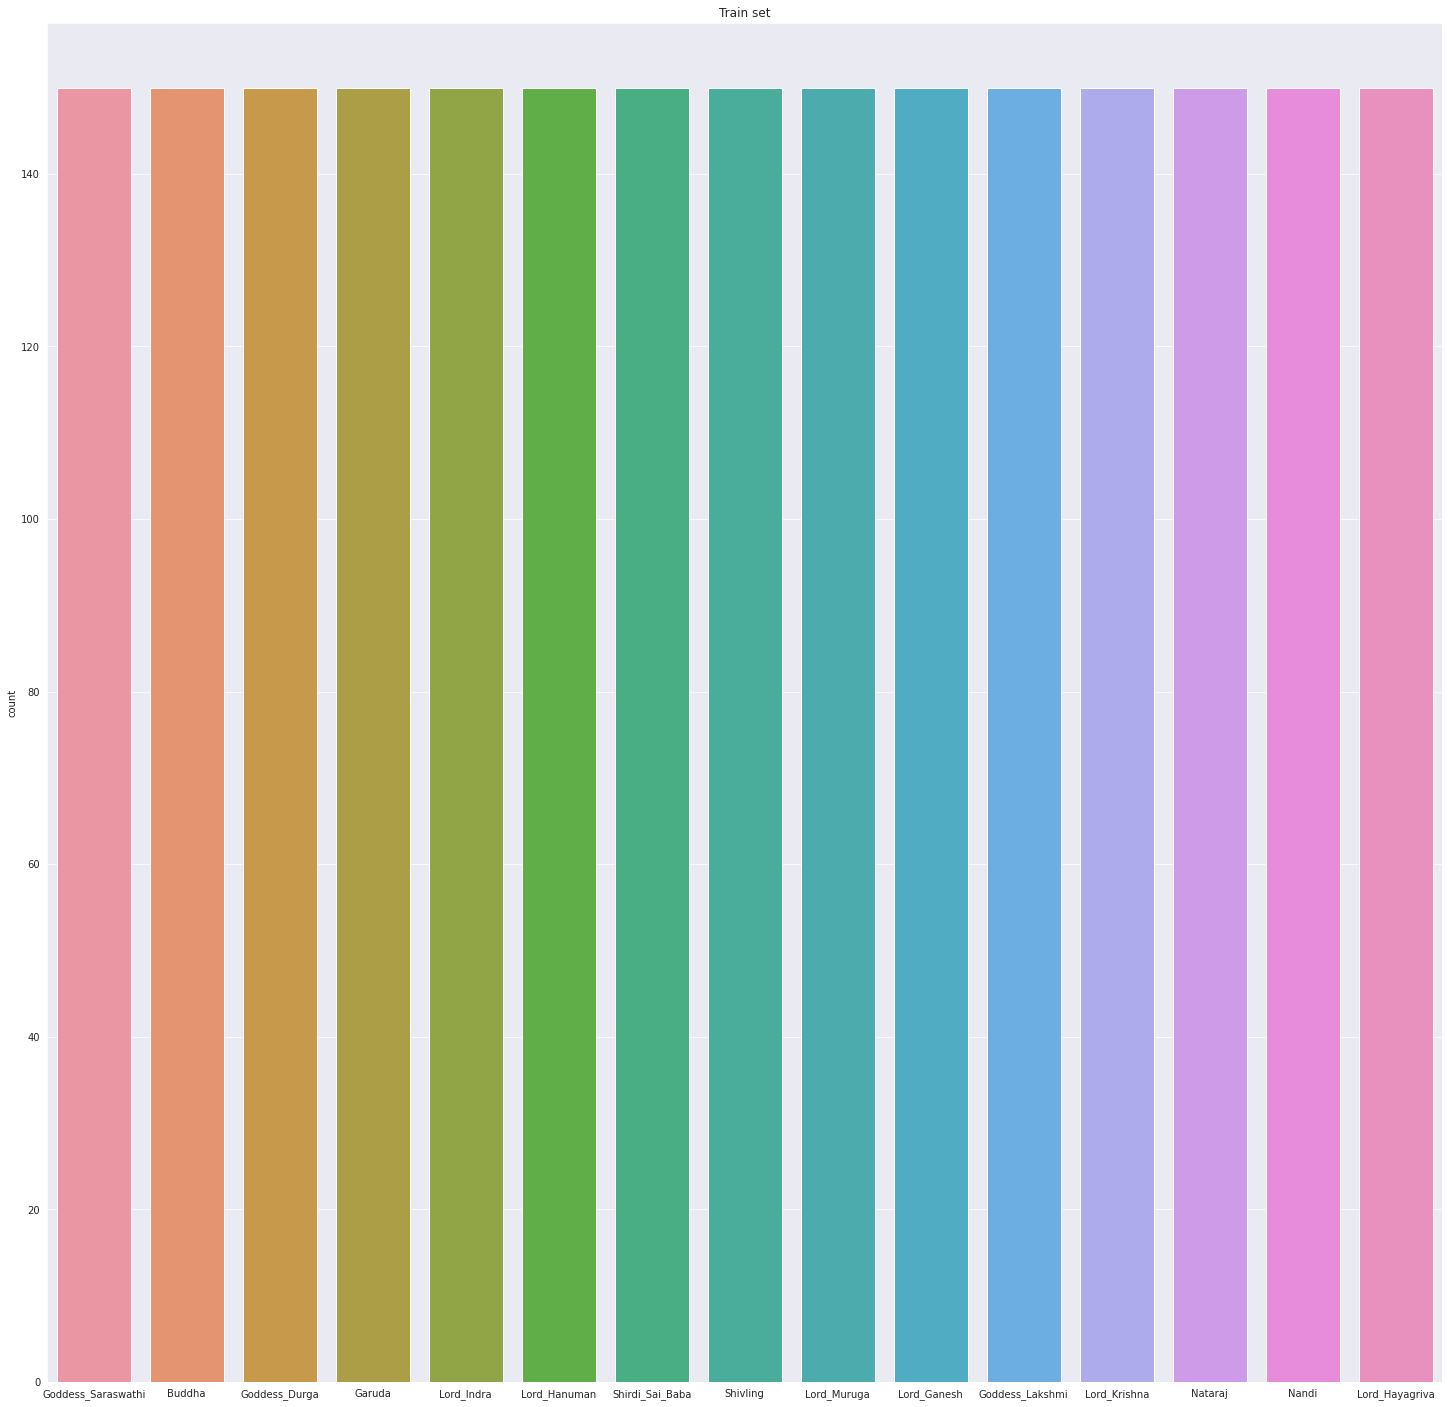

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


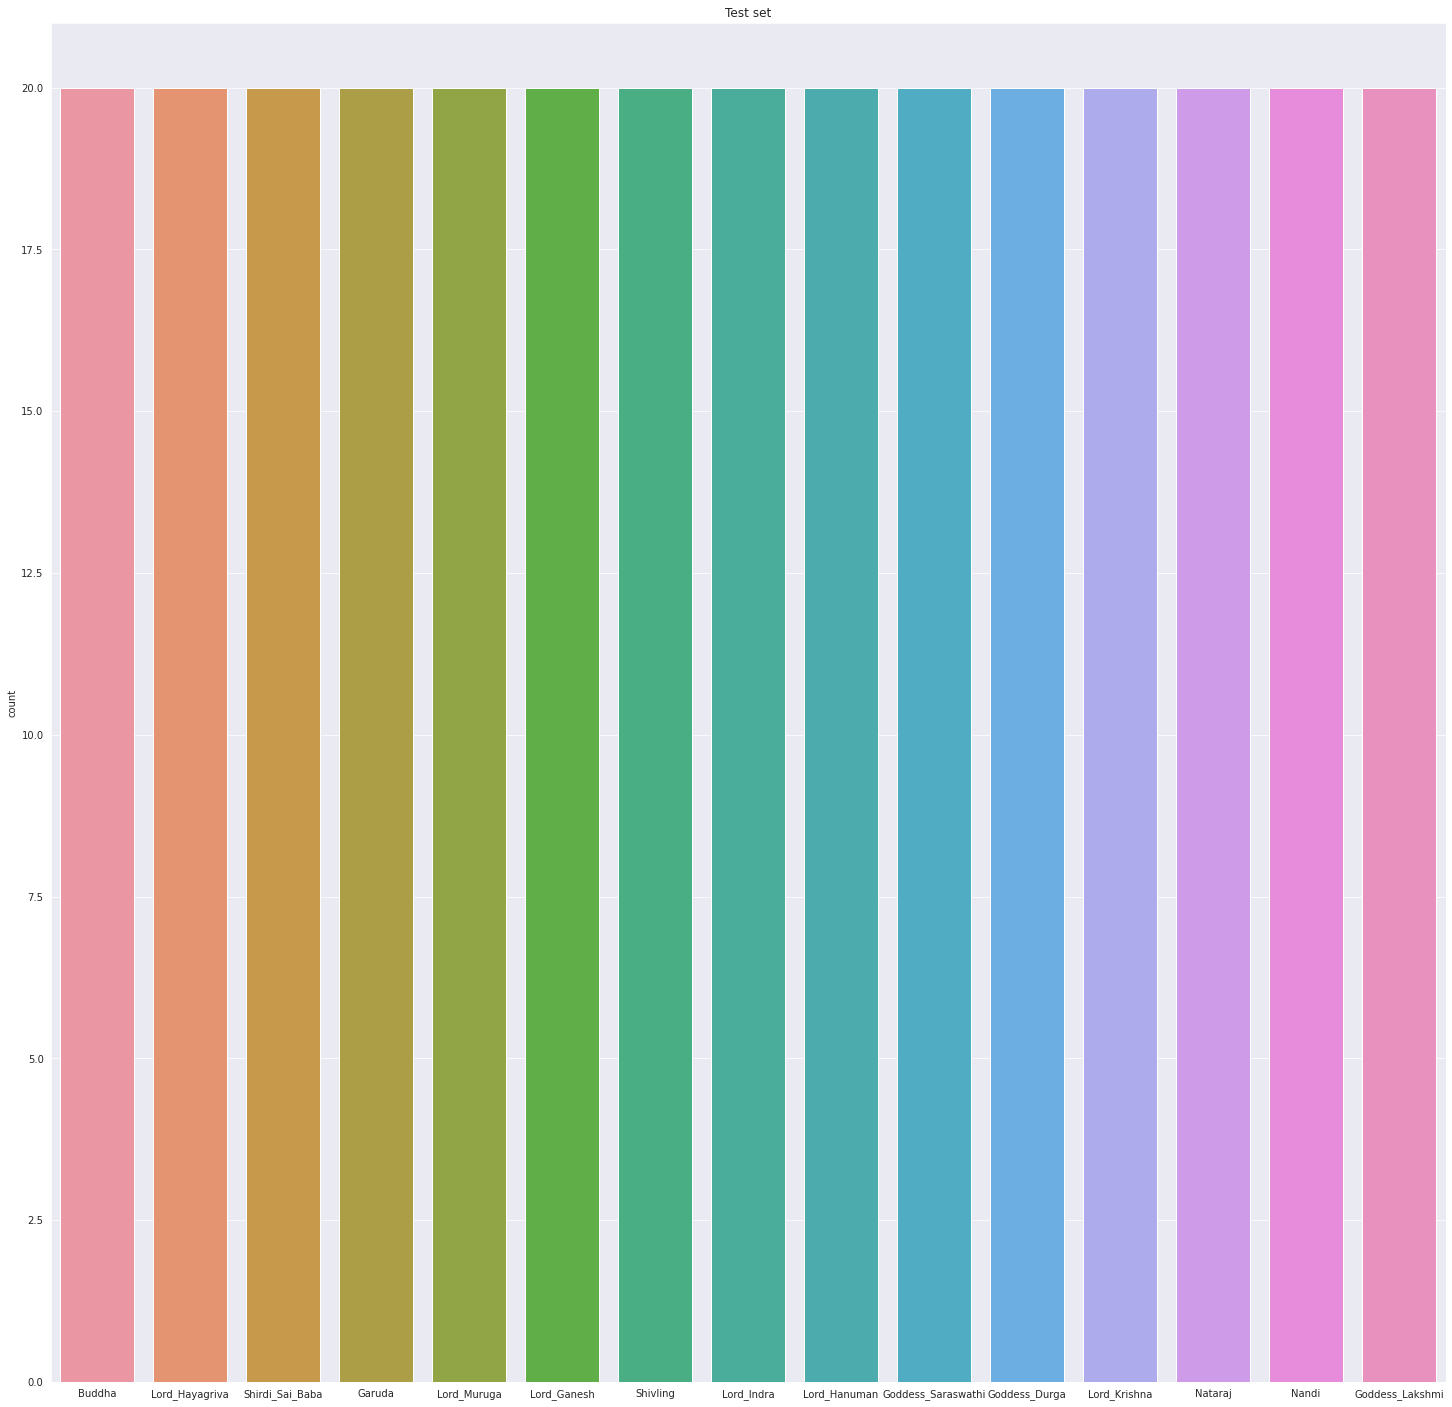

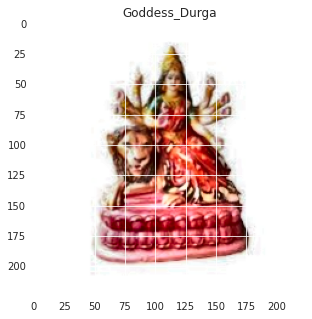

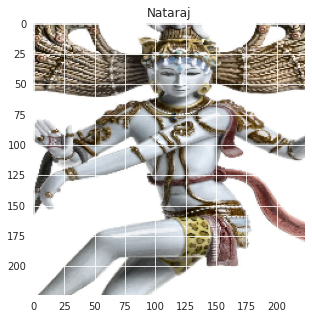

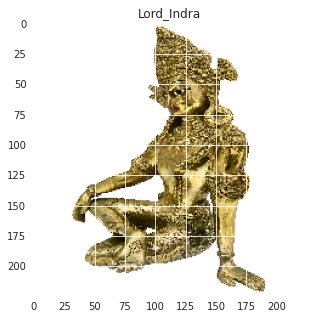

In [18]:
#Stats
dataset_creation_train_stat(labels, train)
dataset_creation_test_stat(labels, test)
show_sample_train(labels, train, num_sample_img)


In [19]:
#Training and testing data
x_train, y_train, x_test, y_test = train_test_data_split(train, test)

#Normalize and array conversion
x_train, y_train, x_test, y_test = normalize_array_conv_data(x_train, y_train, x_test, y_test)

In [20]:
#Building CNN Model
model = build_model_cnn(tot_classes, x_train)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [21]:
#Compile and fit the model
history, model = compile_and_fit(model, x_train, y_train, x_test, y_test, iterations, l_rate)

Epoch 1/70
71/71 [==============================] - 17s 91ms/step - loss: 2.7087 - accuracy: 0.0693 - val_loss: 2.7028 - val_accuracy: 0.0967
Epoch 2/70
71/71 [==============================] - 6s 78ms/step - loss: 2.6953 - accuracy: 0.0804 - val_loss: 2.6465 - val_accuracy: 0.1600
Epoch 3/70
71/71 [==============================] - 6s 79ms/step - loss: 2.5566 - accuracy: 0.1707 - val_loss: 2.2276 - val_accuracy: 0.3167
Epoch 4/70
71/71 [==============================] - 6s 79ms/step - loss: 2.3459 - accuracy: 0.2356 - val_loss: 1.9558 - val_accuracy: 0.3733
Epoch 5/70
71/71 [==============================] - 6s 79ms/step - loss: 2.2170 - accuracy: 0.2871 - val_loss: 1.8493 - val_accuracy: 0.4667
Epoch 6/70
71/71 [==============================] - 6s 78ms/step - loss: 2.1092 - accuracy: 0.3404 - val_loss: 1.6586 - val_accuracy: 0.5133
Epoch 7/70
71/71 [==============================] - 6s 79ms/step - loss: 2.0288 - accuracy: 0.3689 - val_loss: 1.6021 - val_accuracy: 0.5100
Epoch 8/70
7

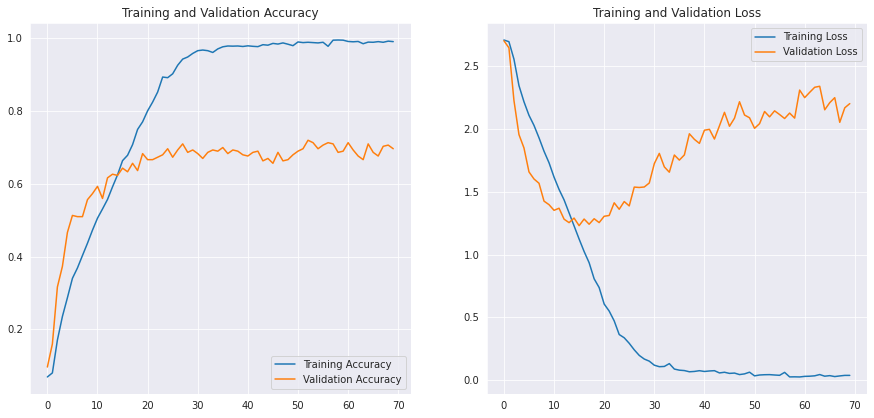

In [22]:
#Plots
acc_plots(history, iterations)

In [23]:
#Results
acc_results(model, labels, x_test, y_test)


                    precision    recall  f1-score   support

            Buddha       0.83      0.75      0.79        20
            Garuda       0.76      0.65      0.70        20
     Goddess_Durga       0.94      0.75      0.83        20
   Goddess_Lakshmi       0.56      0.50      0.53        20
Goddess_Saraswathi       0.56      0.45      0.50        20
       Lord_Ganesh       0.73      0.55      0.63        20
      Lord_Hanuman       0.39      0.35      0.37        20
    Lord_Hayagriva       0.71      0.85      0.77        20
        Lord_Indra       0.80      1.00      0.89        20
      Lord_Krishna       0.71      0.75      0.73        20
       Lord_Muruga       0.52      0.70      0.60        20
             Nandi       0.85      0.85      0.85        20
           Nataraj       0.86      0.95      0.90        20
   Shirdi_Sai_Baba       0.46      0.60      0.52        20
          Shivling       0.88      0.75      0.81        20

          accuracy                    

#### **Result: The accuracy of the CLAHE + CNN model having learning rate = 1*10^(-4) and epochs = 70 is 69.67% (approx).**